# ML MODELS WITH HYPERPARAMETER TUNING

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

In [2]:

# Load the cleaned data
df = pd.read_csv('../Data-Preprocessing/cleaned_data.csv')
text_column = 'tweet'

# Ensure the text column is of string type
df[text_column] = df[text_column].astype(str)


## TF-IDF ENCODING

In [3]:

def tfidf_encoding(df, text_column):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names

# Apply TF-IDF encoding
tfidf_matrix, feature_names = tfidf_encoding(df, text_column)

print("Shape of TF-IDF matrix:", tfidf_matrix.shape)


Shape of TF-IDF matrix: (24766, 18144)


## DATA MODELING AND HANDLING CLASS IMBALANCE

In [4]:
#Prepare Data for Modeling
X = tfidf_matrix
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Apply SMOTE to handle class imbalance in the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## HYPER PARAMETER TUNING

### LOGISTIC REGRESSION

In [5]:
# Hyperparameter Tuning for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=3, n_jobs=-1)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
print("Best Logistic Regression Parameters:", grid_lr.best_params_)
print("Best Logistic Regression Score:", grid_lr.best_score_)


Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression Score: 0.9001110438118313


### SVM

In [6]:
# Hyperparameter Tuning for SVM
param_grid_svm = {
    'C': [0.1, 1, 5, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, n_jobs=-1)
grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
print("Best SVM Parameters:", grid_svm.best_params_)
print("Best SVM Score:", grid_svm.best_score_)


Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM Score: 0.8995053502927518


### RANDOM FOREST

In [7]:
#Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best Random Forest Parameters:", grid_rf.best_params_)
print("Best Random Forest Score:", grid_rf.best_score_)


Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Score: 0.7774076317383405


## MODEL EVALUVATION

In [8]:
# Evaluate the Best Models
models = {
    'Logistic Regression': best_lr,
    'SVM': best_svm,
    'Random Forest': best_rf
}

best_model = None
best_model_name = None
best_accuracy = 0

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {name}")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy}")


Model: Logistic Regression
Accuracy: 0.9002825999192572
Confusion Matrix:
 [[  47  194   41]
 [  31 3605  162]
 [   2   64  808]]


Model: SVM
Accuracy: 0.9014937424303593
Confusion Matrix:
 [[  42  210   30]
 [  22 3645  131]
 [   3   92  779]]


Model: Random Forest
Accuracy: 0.7674606378683891
Confusion Matrix:
 [[   0  282    0]
 [   0 3798    0]
 [   0  870    4]]


Best Model: SVM
Best Accuracy: 0.9014937424303593


## VISUALIZATION

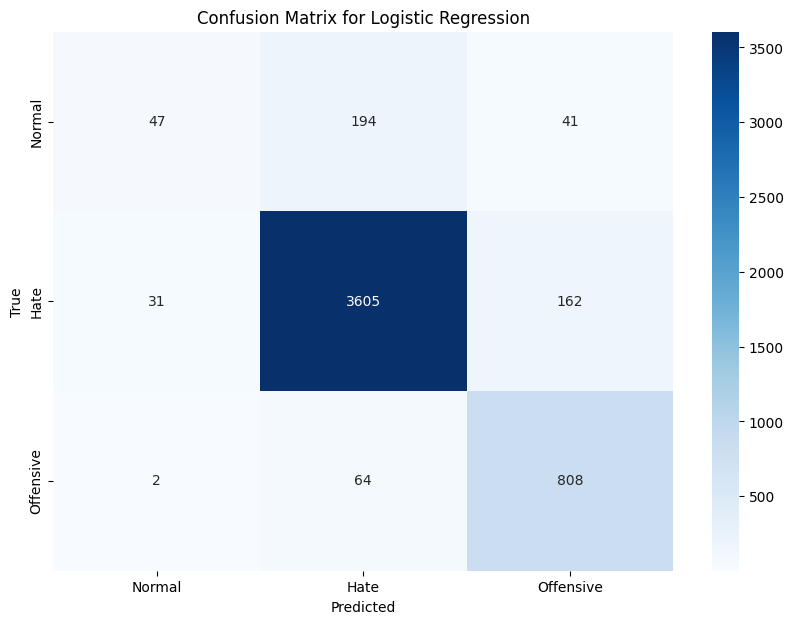

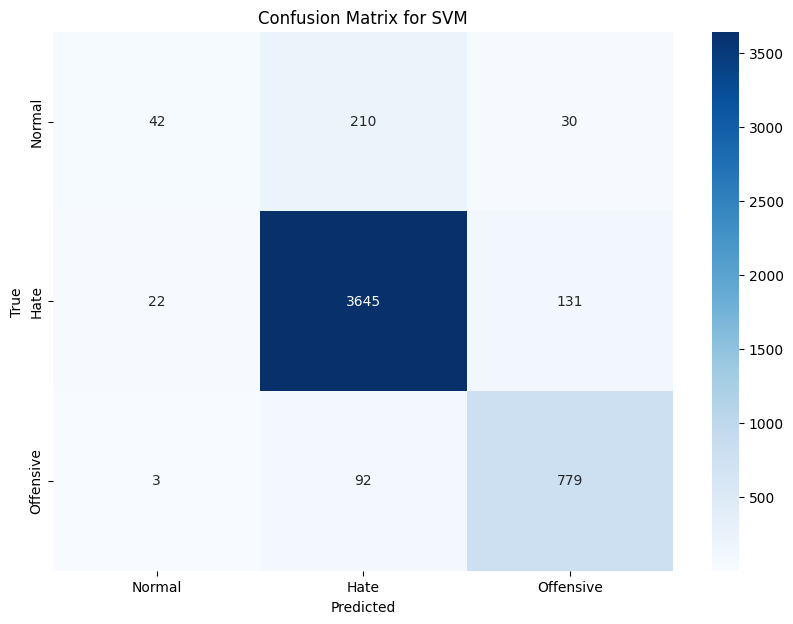

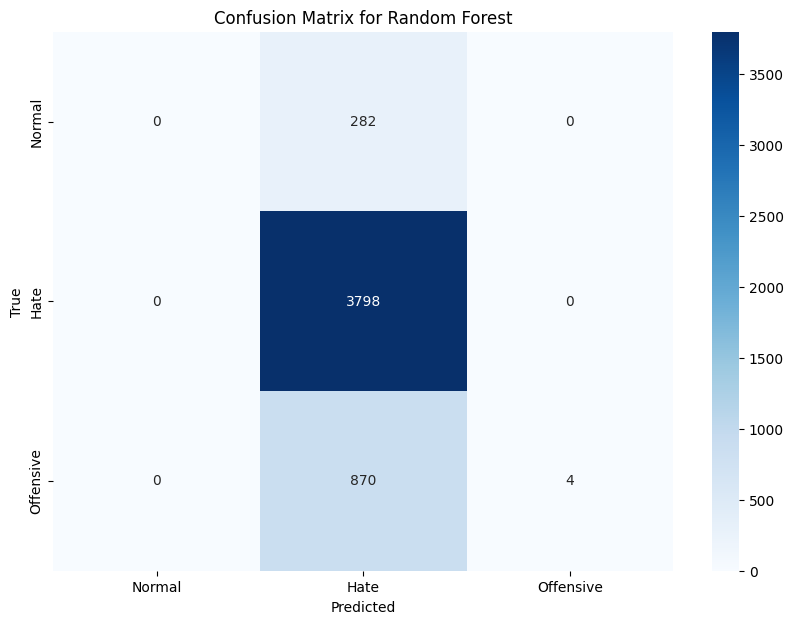

In [9]:

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Hate', 'Offensive'], yticklabels=['Normal', 'Hate', 'Offensive'])
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## SAVING THE BEST MODEL

In [10]:
#Save the Best Model
model_filename = f"{best_model_name.replace(' ', '_').lower()}.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved as {model_filename}.")


Best model saved as svm.pkl.
